**Outline**

The purpose of this script is to plot grand-average TFRs and mu/beta timecourses from the MNS_longISI and buttonPress tasks

**Import packages**

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import seaborn as sns

mne.set_log_level('ERROR')

**User input**

In [2]:
# Define task prefix
dataPre = 'buttonPress'

# How many subjects?
n = '11'

# Sensor pick
pick = 'C3'

# Font size for figures
fontsize = 12

**Define main directories and files**

In [3]:
# Main directories
projectDir = '../'
dataDir = os.path.join(projectDir, 'proc_data')
resultsDir = os.path.join(projectDir, 'results')
supportDir = os.path.join(projectDir, 'support_files')

# Input files
times_fname = os.path.join(resultsDir, f'{dataPre}-sens-tfr-times.npy')
info_fname = os.path.join(resultsDir, f'{dataPre}-sens-tfr-info.fif')
tfrs_fname = os.path.join(resultsDir, f'{dataPre}-trans-cleaned-manRej-baseCorrected-tfrs-{pick}_N={n}.npy')
muTCs_fname = os.path.join(resultsDir, f'{dataPre}-trans-cleaned-manRej-baseCorrected-muTCs-{pick}_N={n}.npy')
betaTCs_fname = os.path.join(resultsDir, f'{dataPre}-trans-cleaned-manRej-baseCorrected-betaTCs-{pick}_N={n}.npy')
bfs_fname = os.path.join(resultsDir, f'{dataPre}_{pick}_and_label_mu_beta_stats_N={n}.csv')
magns_fname = os.path.join(resultsDir, f'{dataPre}_{pick}_and_label_mu_beta_magnitudes_N={n}.csv')
bad_subjects_fname = os.path.join(supportDir, f'{dataPre}_bad_subjects.txt')


**Load and prepare the data for plotting**

In [4]:
# Load data
tfr_data = np.load(tfrs_fname, allow_pickle=True)
muTCs = np.load(muTCs_fname, allow_pickle=True)
betaTCs = np.load(betaTCs_fname, allow_pickle=True)
bfs = pd.read_csv(bfs_fname)
magns = pd.read_csv(magns_fname)

times = np.load(times_fname, allow_pickle=True)
info = mne.io.read_info(info_fname)

print(f"times shape: {times.shape}")
print(f"tfr data shape: {tfr_data.shape}")
print(f"mu timecourses shape: {muTCs.shape}")
print(f"beta timecourses shape: {betaTCs.shape}")



times shape: (7001,)
tfr data shape: (11, 1, 39, 7001)
mu timecourses shape: (11, 1, 7001)
beta timecourses shape: (11, 1, 7001)


In [7]:
# Plug the TFR data into an MNE object for easy plotting. The object will treat subjects as epochs
tfrs = mne.time_frequency.EpochsTFRArray(info, tfr_data, times, np.arange(1, 40, 1))

# Average over subjects
gavg_tfr = tfrs.average()

# Average the timecourse data across subjects and compute standard errors
gavg_muTC = np.mean(muTCs, axis=0).squeeze()
gavg_betaTC = np.mean(betaTCs, axis=0).squeeze()

se_muTC = np.std(muTCs, axis=0) / np.sqrt(muTCs.shape[0])
se_betaTC = np.std(betaTCs, axis=0) / np.sqrt(betaTCs.shape[0])

se_muTC = se_muTC.squeeze()
se_betaTC = se_betaTC.squeeze()


# Convert bfs and magns to long format for easy plotting
bfs_long = pd.melt(bfs, id_vars=['label'], var_name='effect', value_name='bf')
# Drop na rows
bfs_long = bfs_long.dropna(subset=['bf'])

# Convert magns to long format
magns_long = pd.melt(magns, id_vars=['label'], var_name='peak')

# Split the 'value' column (which contains lists) into separate columns
split_values = magns_long['value'].str.split(',', expand=True)
magns_long = pd.concat([magns_long.drop(columns=['value']), split_values], axis=1)

# Wrangle back to long format
magns_long = magns_long.melt(id_vars=['label', 'peak'],  
											value_name='magnitude')

# Convert the 'magnitude' column to numeric
magns_long['magnitude'] = pd.to_numeric(magns_long['magnitude'], errors='coerce')

# Separate bfs and magnitudes for the selected sensor and labels
bfs_sens = bfs[bfs['label'] == pick]
magns_sens = magns[magns['label'] == pick]

# Split into sensor and label data
bfs_long_sens = bfs_long[bfs_long['label'] == 'C3']
bfs_long_labels = bfs_long[bfs_long['label'] != 'C3']
magns_long_sens = magns_long[magns_long['label'] == 'C3']
magns_long_labels = magns_long[magns_long['label'] != 'C3']

**Plot the grand-average TFR at C3**

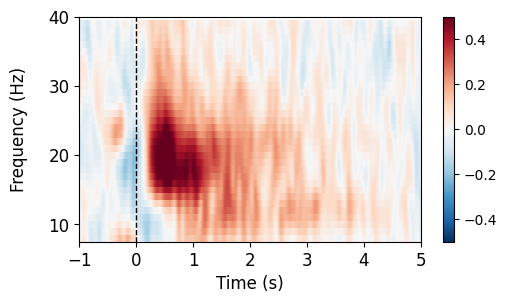

In [8]:
fig = gavg_tfr.copy().crop(-1,5).plot(fmin=8, vlim=(-0.5, 0.5), colorbar=True, show=False)

# Adjust figure parameters
fig[0].set_size_inches(5,3) # size
fig[0].axes[0].set_xticks(np.arange(-1, 6, 1))  # prevent x axis ticks changing with figure size
fig[0].axes[0].set_yticks(np.arange(10, 50, 10))  # prevent y axis ticks changing with figure size


# Add a line at x=0
fig[0].axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
fig[0].axes[0].set_xlabel('Time (s)', fontsize=fontsize)
fig[0].axes[0].set_ylabel('Frequency (Hz)', fontsize=fontsize)
fig[0].axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

# Move ylabel closer to the y axis
fig[0].axes[0].yaxis.set_label_coords(-0.15, 0.5)  # Adjust the x-coordinate to move it closer to the y-axis


**Plot timecourses at C3**

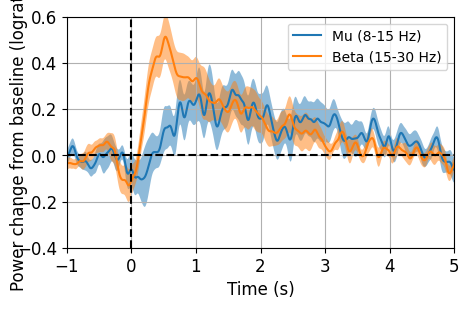

In [9]:
# Plot the beta timecourses
plt.figure(figsize=(5,3))

# Plot mu
plt.plot(times, gavg_muTC, label='Mu (8-15 Hz)')
plt.fill_between(times, gavg_muTC - se_muTC, gavg_muTC + se_muTC, alpha=0.5)


# Plot beta
plt.plot(times, gavg_betaTC, label='Beta (15-30 Hz)')
plt.fill_between(times, gavg_betaTC - se_betaTC, gavg_betaTC + se_betaTC, alpha=0.5)

# Add lines for 0 on each axis
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.grid()

# Axis labels
plt.xlabel('Time (s)', fontsize=fontsize)
plt.ylabel('Power change from baseline (logratio)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)

# Move ylabel closer to the y axis
plt.gca().yaxis.set_label_coords(-0.1, 0.5)

# Crop x and y axis
plt.xlim(-1, 5)
plt.ylim(-0.4, 0.6)

# Show lgened
plt.legend()

**Plot both in a single figure**

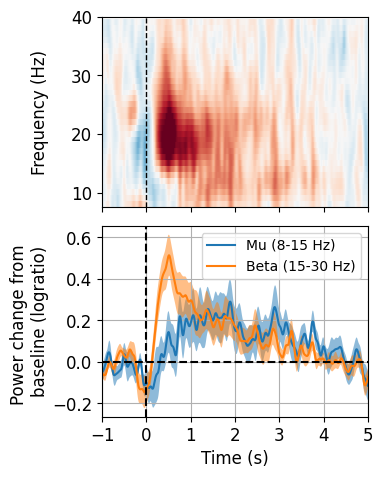

In [29]:
fig, ax = plt.subplots(2,1, figsize=(4,5), sharex=True)

# Flatten ax array for easy indexing
ax = ax.flatten()

#######
# Plot TFR
gavg_tfr.copy().crop(-1,5).plot(fmin=8, vlim=(-0.5, 0.5), colorbar=False, 
								show=False, axes=ax[0])

# Adjust figure parameters
ax[0].set_xticks(np.arange(-1, 6, 1))  # prevent x axis ticks changing with figure size
ax[0].set_yticks(np.arange(10, 50, 10))

# Add a line at x=0
ax[0].axvline(0, color='k', linestyle='--', linewidth=1)
ax[0].set_xlabel('', fontsize=fontsize)
ax[0].set_ylabel('Frequency (Hz)', fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)

# Move ylabel closer to the y axis
ax[0].yaxis.set_label_coords(-0.15, 0.5)  # Adjust the x-coordinate to move it closer to the y-axis



#######
# Plot mu/beta timecourses

# Plot mu
ax[1].plot(times, gavg_muTC, label='Mu (8-15 Hz)')
ax[1].fill_between(times, gavg_muTC - se_muTC, gavg_muTC + se_muTC, alpha=0.5)


# Plot beta
ax[1].plot(times, gavg_betaTC, label='Beta (15-30 Hz)')
ax[1].fill_between(times, gavg_betaTC - se_betaTC, gavg_betaTC + se_betaTC, alpha=0.5)

# Add lines for 0 on each axis
ax[1].axhline(0, color='black', linestyle='--')
ax[1].axvline(0, color='black', linestyle='--')
ax[1].grid()

# Axis labels
ax[1].set_xlabel('Time (s)', fontsize=fontsize)
ax[1].set_ylabel('Power change from \nbaseline (logratio)', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)

# Move ylabel closer to the y axis
ax[0].yaxis.set_label_coords(-0.2, 0.5)
ax[1].yaxis.set_label_coords(-0.2, 0.5)


# Crop x and y axis
ax[1].set_xlim(-1, 5)
# ax[1].set_ylim(-0.4, 0.6)

# Show lgened
ax[1].legend()

# Figure params

# Adjust layout
plt.tight_layout(pad=1)

